In [4]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mploties3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats.qmc import LatinHypercube


np.random.seed(1234)

In [31]:
# --------------------------------------------------------------
# 1. True 4D test function (highly non-linear)
# --------------------------------------------------------------

def f_simple(X):
    x1, x2 = X[:,0], X[:,1]
    return 0.5*x1 + 0.2*x2

def f_normal(X):
    x1, x2 = X[:,0], X[:,1]
    return (
        np.sin(x1) * np.cos(0.5*x2) +
        0.3 * np.sin(2*x1) +
        0.05*(x1**2 + x2**2 )
    )
def f_complicated(X):
    x1, x2= X[:,0], X[:,1]

    # Rastrigin-like term for multi-modality
    ras = (x1**2 - 10*np.cos(2*np.pi*x1) +
           x2**2 - 10*np.cos(2*np.pi*x2))

    # Nonlinear interactions
    cross = np.sin(3*x1*x2) 

    # High frequency terms
    osc = 0.2*np.sin(5*x1 + x2) 

    return 0.1*ras + cross + osc
# Bounds for each dimension
bounds = np.array([[-2, 2], [-2, 2]])

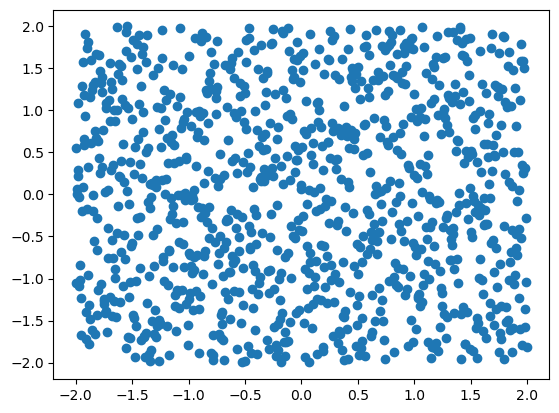

In [32]:
f="f_complicated"
# --------------------------------------------------------------
# 2. Training data (Latin Hypercube would be better for 4D, here random for simplicity)
# --------------------------------------------------------------
np.random.seed(42)
n_train = 1000
# X_train = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_train, 4))

engine = LatinHypercube(d=2)
X_train = engine.random(n=1000)

(x_lo, x_hi), (y_lo, y_hi) = bounds
X_train[:, 0] = x_lo + X_train[:, 0] * (x_hi - x_lo)
X_train[:, 1] = y_lo + X_train[:, 1] * (y_hi - y_lo)



if f=="f_simple":
    y_train=f_simple(X_train).ravel()
elif f=="f_normal":
    y_train=f_normal(X_train).ravel()
else:
    y_train=f_complicated(X_train).ravel()
# y_train = true_function(X_train).ravel()

# Add a tiny noise
y_train += np.random.normal(0, 0.1, size=y_train.shape)

X_train.shape, y_train.shape

plt.scatter(X_train[:,0],X_train[:,1])

In [33]:
# --------------------------------------------------------------
# 3. Fit Gaussian Process 
# --------------------------------------------------------------
kernel = C(1.0) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1e-2)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, normalize_y=True, n_restarts_optimizer=5)
gp.fit(X_train, y_train)

print("Fitted kernel:", gp.kernel_)
print("Log-marginal-likelihood:", gp.log_marginal_likelihood_value_)

Fitted kernel: 2.75**2 * RBF(length_scale=0.46) + WhiteKernel(noise_level=0.00638)
Log-marginal-likelihood: 617.3213057390517


In [34]:
# --------------------------------------------------------------
# 4. Prediction on a regular grid 
# --------------------------------------------------------------
n_grid = 50
x1 = np.linspace(-2, 2, n_grid)
x2 = np.linspace(-2, 2, n_grid)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

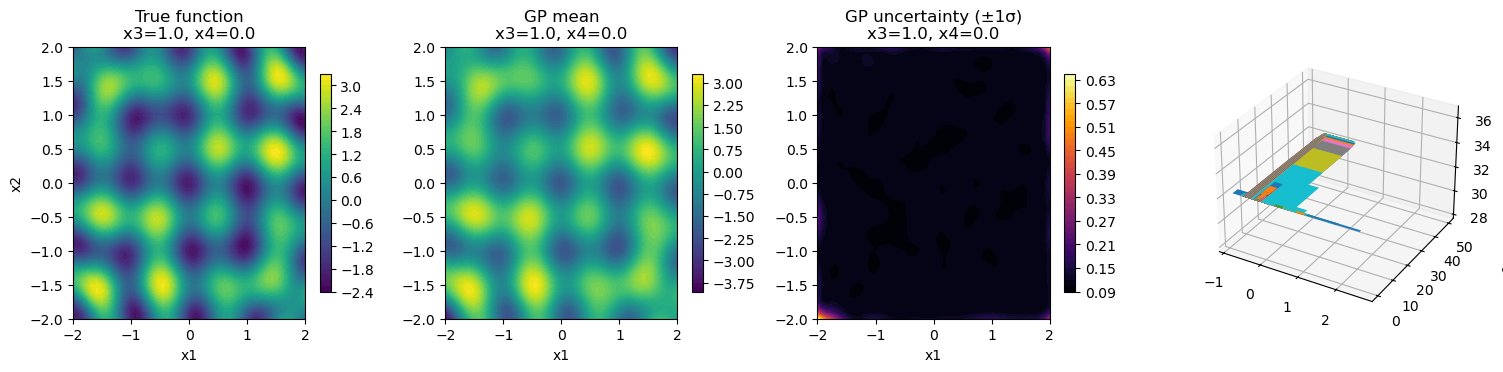

In [37]:
# --------------------------------------------------------------
# 5. Plotting
# --------------------------------------------------------------
fig = plt.figure(figsize=(15, 10))


y_mean, y_std = gp.predict(X_grid, return_std=True)
X_test=np.column_stack([X1.ravel(), X2.ravel()])
if f=="f_simple":
    y_true=f_simple(X_test).reshape(X1.shape)
elif f=="f_normal":
    y_true=f_normal(X_test).reshape(X1.shape)
else:
    y_true=f_complicated(X_test).reshape(X1.shape)


# y_true = true_function(np.column_stack([X1.ravel(), X2.ravel(), np.full_like(X1.ravel(), x3f), np.full_like(X1.ravel(), x4f)])).reshape(X1.shape)
# contour_levels = [0.2, 0.4, 0.6, 0.8, 1.0]
# True function contour
ax1 = fig.add_subplot(3, 4, 4*(i-1)+1)
cp1 = ax1.contourf(X1, X2, y_true, levels=50, cmap='viridis')
plt.colorbar(cp1, ax=ax1, shrink=0.8)
ax1.set_title(f'True function\n{title}')
ax1.set_xlabel('x1'); ax1.set_ylabel('x2')

# GP mean
ax2 = fig.add_subplot(3, 4, 4*(i-1)+2)
cp2 = ax2.contourf(X1, X2, y_mean.reshape(X1.shape), levels=50, cmap='viridis')
plt.colorbar(cp2, ax=ax2, shrink=0.8)
ax2.set_title(f'GP mean\n{title}')
ax2.set_xlabel('x1')

# GP uncertainty (std)
ax3 = fig.add_subplot(3, 4, 4*(i-1)+3)
cp3 = ax3.contourf(X1, X2, y_std.reshape(X1.shape), levels=50, cmap='inferno')
plt.colorbar(cp3, ax=ax3, shrink=0.8)
ax3.set_title(f'GP uncertainty (±1σ)\n{title}')
ax3.set_xlabel('x1')


ax4 = fig.add_subplot(3, 4, 4, projection='3d')
ax4=plt.hist(np.abs(y_true-y_mean.reshape(X1.shape)))
# surf = ax4.plot_surface(X1, X2, y_mean.reshape(X1.shape), cmap='viridis', alpha=0.8)
# ax4.set_title('GP mean (3D surface)\nx3=0, x4=0')
# ax4.set_xlabel('x1'); ax4.set_ylabel('x2'); ax4.set_zlabel('y')

plt.tight_layout()
plt.show()